Taking in, Covariance matrix, mu and number of points to sample

Objective function is literally just the portfolio's variance which we are minimising for each target return. Taken together, then, the set of all solutions for the set of target returns results in the efficient frontiers<br> Objective Function: 
    <center>$\sigma_p^2 = w^T C w$</center>

Cannot, alas, use Lagrangian Optimisation, as we're using range-bounded constraints, rather than strict ones -> using Quadratic Programmming that takes 2nd order Taylor Series multivariate approximation letting $f'(x_0)=0$ and optimises accordingly.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize # Least Squares approach to Quadratic Programming
from numpy.linalg import inv  
from numpy.linalg import pinv  
from sklearn.decomposition import PCA

In [217]:
import yfinance as yf

# if it works, it works
# Fetch S&P 500 company list and sectors from Wikipedia
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
ticker_data = table[0]
tickers = ticker_data['Symbol'].tolist()
ticker_to_sector = {row['Symbol']: row['GICS Sector'] for index, row in ticker_data.iterrows()}
# Fetch historical data for the latest year
# data = yf.download(tickers, start='2022-01-01', end='2023-01-01')['Adj Close']

sector_df = pd.DataFrame(list(ticker_to_sector.items()), columns=['Ticker', 'Sector'])
sector_df.to_csv("Sectors")

In [191]:
sector_df

,Ticker,Sector
0,MMM,Industrials
1,AOS,Industrials
2,ABT,Health Care
3,ABBV,Health Care
4,ACN,Information Technology
...,...,...
498,YUM,Consumer Discretionary
499,ZBRA,Information Technology
500,ZBH,Health Care
501,ZION,Financials


In [205]:
returns = data.pct_change()
returns = returns.iloc[1:]  #removing first zero-row
returns

,A,AAL,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-04,-0.033806,0.014400,-0.012691,-0.001920,-0.009501,-0.023518,0.013019,-0.007146,-0.018374,-0.009032,...,-0.003190,0.006329,0.037614,0.005097,0.010608,0.005347,0.010145,0.006337,0.028487,-0.038072
2022-01-05,-0.017131,-0.017876,-0.026600,0.005253,0.008678,-0.004493,-0.011744,-0.017611,-0.071426,-0.015437,...,-0.037033,0.009799,0.012437,-0.016090,-0.013629,-0.012677,-0.003297,-0.050068,0.002270,-0.038024
2022-01-06,0.003499,-0.005889,-0.016693,-0.004710,-0.015472,-0.000148,0.005830,-0.048290,-0.000603,0.003182,...,0.004629,-0.007822,0.023521,-0.000711,-0.001373,0.010331,-0.008307,-0.005410,0.041075,0.003971
2022-01-07,-0.026623,0.038234,0.000988,-0.002588,0.020468,0.003108,0.004681,-0.019180,-0.006652,-0.026241,...,-0.001063,0.008759,0.008197,0.003202,-0.007992,-0.011467,-0.006050,-0.043771,0.016681,-0.029114
2022-01-10,0.000069,-0.025415,0.000116,0.011195,0.011418,-0.002213,0.021078,0.006069,0.029626,0.009239,...,-0.028149,0.010998,-0.005952,-0.016844,-0.010136,-0.013964,-0.009754,0.008571,-0.007562,0.007153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.001477,0.011943,-0.002798,-0.001041,0.004372,0.001389,0.008433,0.005023,0.005735,0.000550,...,-0.006401,0.012852,0.026445,0.011118,-0.000728,0.000621,0.001106,0.002869,0.003521,0.005033
2022-12-27,0.002144,-0.014162,-0.013878,-0.000674,-0.005941,0.003605,0.003787,-0.002931,-0.009928,-0.010010,...,0.044723,0.009023,0.013894,0.007540,0.009022,0.007758,0.004657,0.011200,0.008050,-0.003156
2022-12-28,-0.009763,-0.016760,-0.030685,-0.004663,-0.009704,-0.006816,-0.016033,-0.008254,-0.020174,-0.011837,...,-0.050279,-0.007203,-0.016426,-0.033988,-0.016076,-0.004542,-0.010135,-0.016574,-0.017813,-0.010117


In [199]:
determinant = np.linalg.det(cov_matrix)
determinant

200552929246208.78

## Making Our Covariance Matrix Invertible
Huge issues here, and it's necessary for us to be able to invert the Covariance matrix. Not only is it important if we want the analytic solution to the efficient frontier with only strict constraints where we can use the Lagrangian method, but we also need it for the Least Squares method of optimization for our Quadratic Programming Optimization

In [218]:
# Have to keep trying to render the matrix non-singular.
def i_hate_this_matrix(returns, sector_df, alpha=1):
    returns = returns.dropna(axis=1, how='any')
    remaining_tickers = returns.columns.tolist()
    sector_df = sector_df[sector_df['Ticker'].isin(remaining_tickers)].reset_index(drop=True)

    cov_matrix = returns.cov() * returns.shape[0]
    cov_matrix = cov_matrix + np.eye(cov_matrix.shape[0]) * alpha
    corr_matrix = returns.corr()
    removed_columns = []

    # now we remove highly correlated columns until we have a non-zero determinant

    initial_determinant = np.linalg.det(cov_matrix)

    removed_columns = []
    current_determinant = initial_determinant

    correlation_threshold = 0.90

    while np.isclose(current_determinant, 0):
        # Recalculate the correlation matrix
        correlation_matrix = returns.corr()
        
        # Find pairs of stocks with correlation above the threshold
        correlated_pairs = []
        for i in range(correlation_matrix.shape[0]):
            for j in range(i+1, correlation_matrix.shape[1]):
                if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                    correlated_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j]))

        
        # Remove one stock from each highly correlated pair
        for pair in correlated_pairs:
            if pair[0] not in removed_columns and pair[1] not in removed_columns:
                removed_columns.append(pair[1])
        
        # Remove the identified stocks from the data
        returns = returns.drop(columns=removed_columns)
        sector_df = sector_df[~sector_df['Ticker'].isin(removed_columns)]
        removed_columns = [] # so we don't try to drop them again
        
        # Recalculate the covariance matrix and its determinant
        cov_matrix = returns.cov()
        current_determinant = np.linalg.det(cov_matrix)
        correlation_threshold -= 0.05
        print(f"Correlation threshold is {correlation_threshold}")

    return returns, sector_df, cov_matrix

In [219]:
returns, sector_df, cov_matrix = i_hate_this_matrix(returns, sector_df)

In [220]:
sector_df = sector_df[sector_df['Ticker'].isin(returns.columns)]
sector_df.shape, returns.shape

((498, 2), (250, 498))

In [196]:
determinant = np.linalg.det(cov_matrix)
determinant

200552929246208.78

Now we can effectively invert our matrix

In [66]:
cov_matrix

,A,AAL,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.124187,0.080526,0.082022,0.025705,0.028760,0.065081,0.038034,0.083327,0.102514,0.085288,...,0.084333,0.030382,0.030034,0.059762,0.079551,0.048374,0.058969,0.099227,0.065002,0.080266
AAL,0.080526,1.314124,0.115114,0.018880,0.040184,0.068185,0.069188,0.100526,0.118786,0.123698,...,0.178233,0.027128,0.022951,0.068121,0.101748,0.072170,0.084284,0.133304,0.117818,0.069799
AAPL,0.082022,0.115114,1.126240,0.018879,0.033797,0.059149,0.040440,0.093104,0.113906,0.098685,...,0.104884,0.035362,0.033745,0.057517,0.077447,0.049308,0.060869,0.117573,0.075731,0.075549
ABBV,0.025705,0.018880,0.018879,1.049907,0.024650,0.027310,0.014405,0.025059,0.018461,0.024075,...,0.010024,0.019093,0.014064,0.024744,0.021426,0.013413,0.021889,0.018358,0.022398,0.028411
ABC,0.028760,0.040184,0.033797,0.024650,1.055395,0.028607,0.029922,0.031801,0.023580,0.029464,...,0.024241,0.024157,0.023840,0.021162,0.026936,0.020785,0.025951,0.029921,0.029724,0.023287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.048374,0.072170,0.049308,0.013413,0.020785,0.037134,0.029571,0.048042,0.051905,0.055240,...,0.066552,0.021981,0.017091,0.031309,0.048809,1.057659,0.037517,0.064767,0.040924,0.039733
ZBH,0.058969,0.084284,0.060869,0.021889,0.025951,0.050423,0.036802,0.063729,0.068613,0.063137,...,0.067919,0.026097,0.023835,0.057952,0.063669,0.037517,1.092584,0.071939,0.061480,0.052219
ZBRA,0.099227,0.133304,0.117573,0.018358,0.029921,0.071898,0.054954,0.108839,0.134659,0.116515,...,0.130710,0.031354,0.038880,0.073279,0.089026,0.064767,0.071939,1.214276,0.094844,0.086938
ZION,0.065002,0.117818,0.075731,0.022398,0.029724,0.057891,0.052078,0.074379,0.071309,0.077459,...,0.108861,0.029923,0.038688,0.061640,0.070730,0.040924,0.061480,0.094844,1.143775,0.056933


In [68]:
# collecting all data in one df
stock_df = pd.DataFrame({
    'Risk': std_dev,  
    'Return': Mu,  
    'Ticker': tickers,
})

In [69]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(stock_df, x='Risk', y='Return', hover_data=['Ticker'])

fig.add_trace(
    go.Scatter(
        x=[min(stock_df['Risk']), max(stock_df['Risk'])],
        y=[0, 0],
        mode='lines',
        line=dict(color='gray', width=2, dash='dash'),
        name='Zero Return Line'
    )
)

fig.update_layout(
    title='Risk vs Return',
    xaxis=dict(
        title='Risk (Standard Deviation)',
        gridcolor='gray',
        gridwidth=0.5
    ),
    yaxis=dict(
        title='Expected Return',
        gridcolor='gray',
        gridwidth=0.5
    ),
    hoverlabel=dict(
        bgcolor='white',
        font=dict(
            size=16,
            family='Rockwell'
        )
    )
)
fig.show()

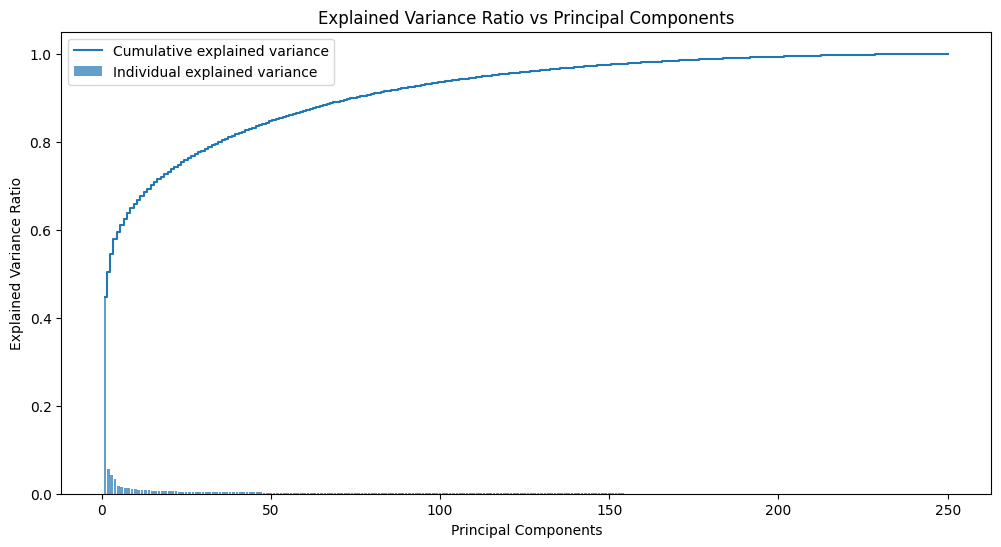

(115,
 array([0.44652246, 0.50378357, 0.54574326, 0.57900255, 0.59562092,
        0.61104829, 0.62489345, 0.63740918, 0.6487441 , 0.65940837,
        0.66859868, 0.67728989, 0.68543169, 0.69338334, 0.70066653,
        0.70757522, 0.71429774, 0.72033336, 0.72628451, 0.73210321,
        0.73761367, 0.74294945, 0.74792513, 0.75284176, 0.75765999,
        0.7622495 , 0.76672487, 0.77116544, 0.77555997, 0.77977976,
        0.78383965, 0.78781649, 0.79170224, 0.79554991, 0.79928111,
        0.80296437, 0.80656034, 0.81005145, 0.81341122, 0.81669567,
        0.81995319, 0.8231294 , 0.82623448, 0.82930594, 0.83226222,
        0.83519841, 0.83803868, 0.84078901, 0.84351903, 0.84619092,
        0.84882734, 0.85141468, 0.85397516, 0.85651034, 0.85898916,
        0.86141266, 0.86376997, 0.86608062, 0.86836195, 0.87062987,
        0.87284142, 0.87501725, 0.87717156, 0.8792931 , 0.88137565,
        0.88340538, 0.88542209, 0.88738094, 0.88927115, 0.89113347,
        0.89297612, 0.89478315, 0.89656399

In [130]:

# Perform PCA on the reduced dataset
pca = PCA()
pca.fit(returns)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual explained variance')
plt.step(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio vs Principal Components')
plt.legend(loc='best')
plt.show()

#calculating the number of components to capture 95% variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
n_components_95 = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1  # Adding 1 as index starts from 0

n_components_95, cumulative_explained_variance[:n_components_95]

Nope, this is where we give up. 
 So let's just move on to the Monte Carlo method and doing some basic risk analysis in the form of limiting exposure to different sectors

In [27]:
sector_df

,Ticker,Sector
0,MMM,Industrials
1,AOS,Industrials
2,ABT,Health Care
3,ABBV,Health Care
4,ACN,Information Technology
...,...,...
498,YUM,Consumer Discretionary
499,ZBRA,Information Technology
500,ZBH,Health Care
501,ZION,Financials


In [117]:
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Constraints
def sum_weights_constraint(weights):
    return np.sum(weights) - 1

def return_constraint(weights, target_return, expected_return):
    return expected_return.T @ weights - target_return

In [247]:
def efficient_frontier_no_constraints(returns, cov_matrix, num_points=100):
    """Calculate the efficient frontier without constraints with debug information."""
    Mu = returns.mean(axis=0) * returns.shape[0] # annualising
    target_returns = np.linspace(-0.2, 0.3, num_points)
    
    num_assets = len(Mu)
    portfolio_risks = []
    portfolio_returns = []


    for target in target_returns:
        # Constraints
        constraints = ({'type': 'eq', 'fun': sum_weights_constraint},
                       {'type': 'eq', 'fun': lambda weights: return_constraint(weights, target, Mu)})

        # Bounds: weights are bound between 0 and 1
        bounds = [(0, 1) for asset in range(num_assets)]

        # Initial guess: Equal distribution
        init_guess = [1./num_assets for asset in range(num_assets)]
        print(len(init_guess))

        # Run the optimizer
        result = minimize(portfolio_variance, init_guess, args=(cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

        # Print the optimization result for debugging
        print(f"Target Return: {target:.4f}, Success: {result.success}, Message: {result.message}")
        
        if result.success:
            portfolio_risks.append(np.sqrt(result.fun))
            portfolio_returns.append(target)

    return portfolio_risks, portfolio_returns




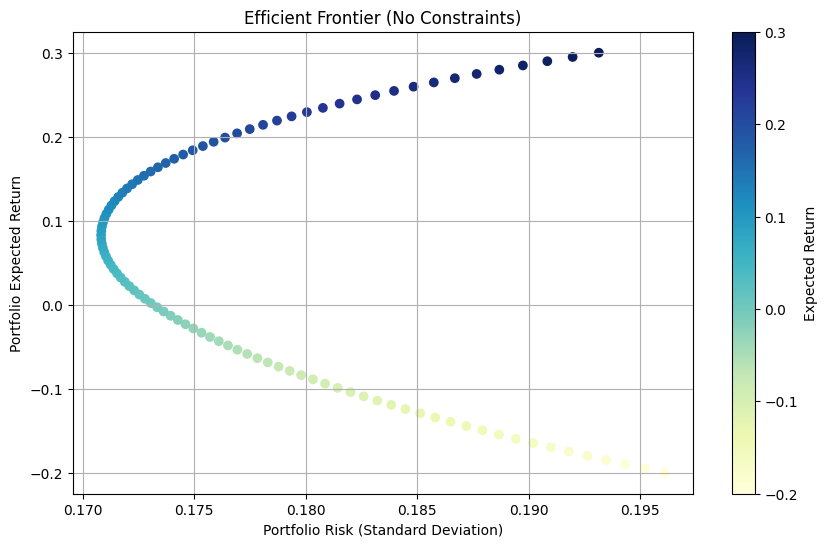

In [251]:
# portfolio_risks, portfolio_returns = efficient_frontier_no_constraints(returns, cov_matrix)

plt.figure(figsize=(10, 6))
plt.scatter(portfolio_risks, portfolio_returns, c=portfolio_returns, cmap='YlGnBu', marker='o')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Expected Return')
plt.title('Efficient Frontier (No Constraints)')
plt.colorbar(label='Expected Return')
plt.grid(True)
plt.show()

Now that is one nice efficient frontier! Although the Sharpe Ratio seems high? (Maybe the linear space of target_returns should be weighted more towards the actually relevant part of the efficient frontier)

In [248]:
def efficient_frontier_with_constraints(returns, cov_matrix, sector_mapping, tech_max=0.1, finance_max=0.1, num_points=50):
    Mu = returns.mean(axis=0) * returns.shape[0]
    Nu = len(Mu)

    target_returns = np.linspace(-0.2, 0.3, num_points)
    
    num_assets = len(Mu)
    portfolio_risks = []
    portfolio_returns = []
    
    # Defining the objective function
    def objective(weights): 
        return weights @ cov_matrix @ weights
    
    # Constraints
    def constraint1(weights):
        return np.sum(weights) - 1
    
    def constraint2(weights, target_return):
        return Mu @ weights - target_return
    
    def constraint_tech(weights):
        tech_weights = np.array([weights[i] for i, ticker in enumerate(sector_mapping.keys()) if sector_mapping.get(ticker, '') == 'Information Technology'])
        return tech_max - np.sum(tech_weights)
    
    def constraint_finance(weights):
        finance_weights = np.array([weights[i] for i, ticker in enumerate(sector_mapping.keys()) if sector_mapping.get(ticker, '') == 'Financials'])
        return finance_max - np.sum(finance_weights)
    
    
    # Run optimization
    for target in target_returns:
        constraints = ({'type': 'eq', 'fun': constraint1},
                {'type': 'eq', 'fun': lambda weights: constraint2(weights, target)},
                {'type': 'ineq', 'fun': constraint_tech},   # Note the inequality condition instead of strict equality sign - this is why we're using Quadratic programmign!
                {'type': 'ineq', 'fun': constraint_finance})
        
        bounds = [(0, 1) for asset in range(Nu)]
        init_guess = [1./num_assets for asset in range(num_assets)]
        
        result = minimize(portfolio_variance, init_guess, args=(cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

        print(f"Target Return: {target:.4f}, Success: {result.success}, Message: {result.message}")

        if result.success:
            portfolio_risks.append(np.sqrt(result.fun))
            portfolio_returns.append(target)

    return portfolio_risks, portfolio_returns

Target Return: -0.2000, Success: True, Message: Optimization terminated successfully
Target Return: -0.1898, Success: True, Message: Optimization terminated successfully
Target Return: -0.1796, Success: True, Message: Optimization terminated successfully
Target Return: -0.1694, Success: True, Message: Optimization terminated successfully
Target Return: -0.1592, Success: True, Message: Optimization terminated successfully
Target Return: -0.1490, Success: True, Message: Optimization terminated successfully
Target Return: -0.1388, Success: True, Message: Optimization terminated successfully
Target Return: -0.1286, Success: True, Message: Optimization terminated successfully
Target Return: -0.1184, Success: True, Message: Optimization terminated successfully
Target Return: -0.1082, Success: True, Message: Optimization terminated successfully
Target Return: -0.0980, Success: True, Message: Optimization terminated successfully
Target Return: -0.0878, Success: True, Message: Optimization term

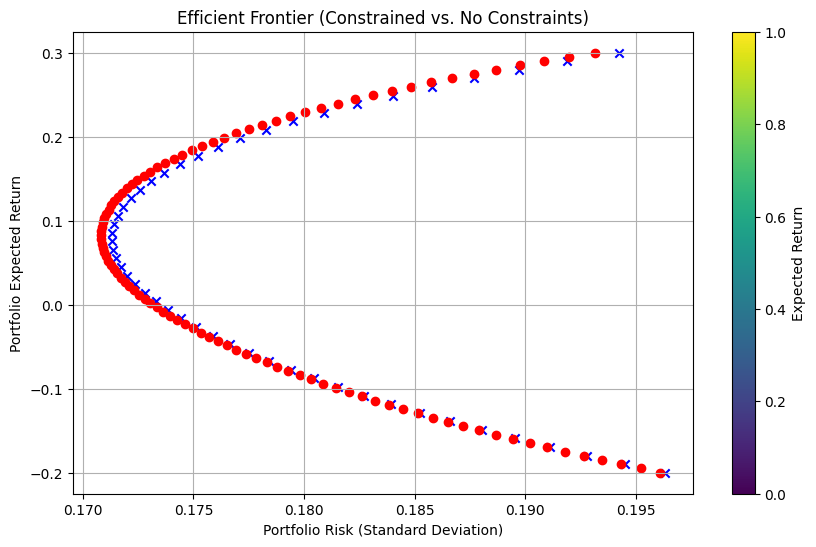

In [250]:
sector_mapping = pd.Series(sector_df.Sector.values, index=sector_df.Ticker).to_dict()

plt.figure(figsize=(10, 6))

portfolio_risks, portfolio_returns = efficient_frontier_with_constraints(returns, cov_matrix, sector_mapping)
plt.scatter(portfolio_risks, portfolio_returns, color="blue", marker='x')

portfolio_risks, portfolio_returns = efficient_frontier_no_constraints(returns, cov_matrix)
plt.scatter(portfolio_risks, portfolio_returns, color="red", marker='o')

plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Expected Return')
plt.title('Efficient Frontier (Constrained vs. No Constraints)')
plt.colorbar(label='Expected Return')
plt.grid(True)
plt.show()

Apparent that constraining the set of possible portfolios lowers the efficient frontier that's accessible. Interestingly, this constraint of capping exposure to financial and tech sector to 10% of portfolio is not very significant